In [82]:
import numpy as np
from numpy.linalg import inv
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

%matplotlib inline

# Load the data set and weight for the numbers we
# will identify
dataDict   = scipy.io.loadmat('./data/ex3data1.mat')
weightDict = scipy.io.loadmat('./data/ex3weights.mat')

X = dataDict['X']
y = dataDict['y']

In [83]:
print("data keys", dataDict.keys())
print("weight keys", weightDict.keys())
print("X shape={0}\ny shape={1}".format(X.shape, y.shape))
print("Theta1 shape={0}\nTheta2 shape={1}".format(weightDict['Theta1'].shape, weightDict['Theta2'].shape))

data keys dict_keys(['y', '__globals__', '__version__', 'X', '__header__'])
weight keys dict_keys(['Theta2', '__globals__', '__version__', 'Theta1', '__header__'])
X shape=(5000, 400)
y shape=(5000, 1)
Theta1 shape=(25, 401)
Theta2 shape=(10, 26)


In [84]:
def DisplayFunc(imageArray, startRow, displayRows, displayCols):
    ''' 
    imageArray  : vectorized rows of m X n image
    startRow    : row to start from in imageArray
    displayRows : number of rows to display on screen
    displayCols : number of columns to display on screen
    '''
    m, n = imageArray.shape

    fig = plt.figure(figsize=(2. * displayCols, 2.26 * displayRows))
    gs = gridspec.GridSpec(displayRows, displayCols, wspace=0.0025, hspace=0.0025)

    ax = [plt.subplot(gs[i]) for i in range(displayRows * displayCols)]
    gs.update(hspace=0)
    gs.tight_layout(fig, pad=0, h_pad=0, w_pad=0)

    for i, im in enumerate(imageArray[startRow:startRow + displayRows * displayCols]):
        vmax = max(im.max(), -im.min())
        ax[i].imshow(im.reshape(20,20), cmap=plt.cm.gray,
                     interpolation='nearest', vmin=-vmax, vmax=vmax)
        ax[i].axis('off')
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_aspect('equal')

    plt.show()


In [16]:
#DisplayFunc(dataDict['X'], 1000, 10, 5)

In [85]:
class LogisticRegressor():
    
    def __init__(self, X, y, theta, rlambda):
        self._X       = X
        self._y       = y
        self._m       = X.shape[0] # number of samples
        self._theta   = theta
        self._rlambda = rlambda    # regularization lambda (0 for no regularization)
    
    def computeCost(self):        
        # hypothesis is:
        #   h_theta(x) = g(theta(0) * x(0) + theta(1) * x(1) + ... + theta(n) * x(n))
        #
        # g is the sigmoid function:
        #   g(z) = 1 / (1 + exp(-z))
        #
        # Cost function is:
        #   J(theta) = -1/m * ((yTranspose * log(h)) + ((1 - y)Transpose * log(1 - h)))
        #
        inner = np.dot(self._X, self._theta)
        
        # This is the sigmoid function giving us values between 0 and 1
        h_theta_x = 1 / (1 + np.exp(-inner))
        
        # Finally here is our cost function using those values between 0 and 1
        sum = (np.dot(np.transpose(self._y), np.log(h_theta_x)) +
               np.dot(np.transpose(1 - self._y), np.log(1 - h_theta_x)))
        
        return (-(sum / self._m) + 
                 (self._rlambda / (2 * self._m) * np.sum(np.square(self._theta[1:]))))
    # end of computeCost

    def predict(self, xin):
        # column 0 should be Ones
        assert (xin[0] == 1)
        inner = np.dot(xin, self._theta)
        return (1 / (1 + np.exp(-inner)))
    
    def gradientDescent(self, alpha, iters):
        
        # how many thetas are we computing. Theta is
        # a column vector
        ntheta = self._theta.shape[0]
        
        cost = np.zeros(iters)
        
        # for maximum number of gradient descent
        # iterations
        for ndescent in range(iters):
            
            # hypothesis is:
            #   h_theta(x) = g(theta(0) * x(0) + theta(1) * x(1) + ... + theta(n) * x(n))
            #
            # g is the sigmoid function:
            #   g(z) = 1 / (1 + exp(-z))
            #
            inner = np.dot(self._X, self._theta)
            
            # This is the sigmoid function giving us values between 0 and 1
            h_theta_x = 1 / (1 + np.exp(-inner))
                 
            n1 = h_theta_x - self._y
                        
            # _X of 5000 samples would be (5000 x 1))
            n2 = np.dot(np.transpose(self._X[:,0:1]), n1)
            
            n3 = alpha * (1 / self._m) * n2
            self._theta[0] = self._theta[0] - n3
            #print("shape n1=", n1.shape, "n2=", n2.shape, "n3=", n3.shape)
          
            # _X of 5000 samples and 20 features would be (5000 x (20 - 1))
            n2 = np.dot(np.transpose(self._X[:,1:]), n1)
            
            n3 = alpha * ((1 / self._m) * n2 + (self._rlambda / self._m) * self._theta[1:])
            self._theta[1:] = self._theta[1:] - n3
            #print("shape n1=", n1.shape, "n2=", n2.shape, "n3=", n3.shape)
            
            cost[ndescent] = self.computeCost()
        # end for ndescent

        return self._theta, cost
    # end gradientDescent

In [86]:
# The matlab y vector has a 10 signifying a image of 0 (Zero)
# Switch that to just 0 for python
ymod = np.copy(y)
ymod[:][y == 10] = 0


In [87]:
yversus = []

# produce new copies of target arrays for each unique
# value in the target namespace.  Each of these
# new arrays will have their y values changed to be
# either (1) or (0).  If y is set to 1 then this
# sample represents a positive example of features for 
# the specific target name.   
#
# E.G. target_names = [ 'zero', 'one', 'two' ]
#      targets      = [ 0, 0, 0, 2, 2, 2, 2, 1, 1]
#      ydict['one'] = [ 0, 0, 0, 0, 0, 0, 0, 1, 1]
#     ydict['zero'] = [ 1, 1, 1, 0, 0, 0, 0, 0, 0]
#      ydict['two'] = [ 0, 0, 0, 1, 1, 1, 1, 0, 0]
#
# What we're producing here is multiple sets of target values so
# that we can run multiple iterations of logistic regression
# building hypothesis (unique theta values) for each unique target
# name.   Basically this is the "one versus the rest" approach
# for logistic regression
# 
for i in range(10):  # ten different digits
    mask = np.copy(ymod)
    mask[:][ymod == i] = 1
    mask[:][ymod != i] = 0
    yversus.append(mask)

In [88]:
# At column 0 insert a Ones column
XOnes = np.insert(X, 0, 1, axis=1)
XOnes.shape

(5000, 401)

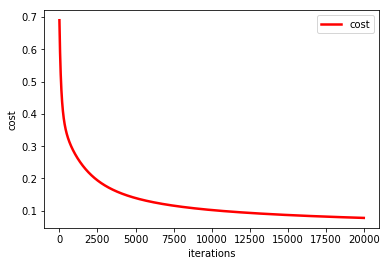

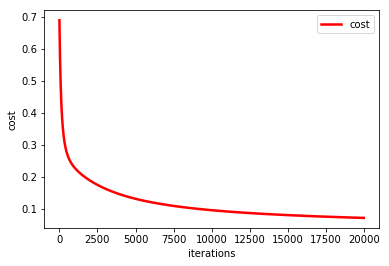

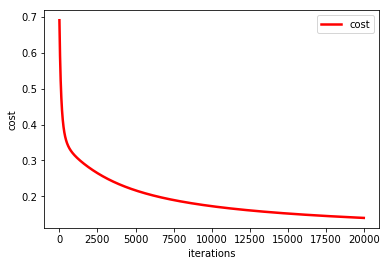

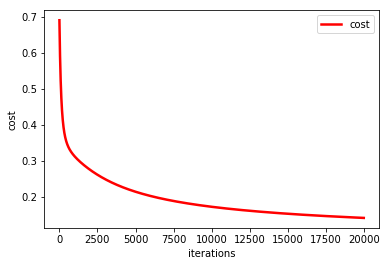

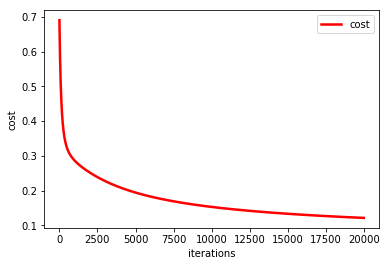

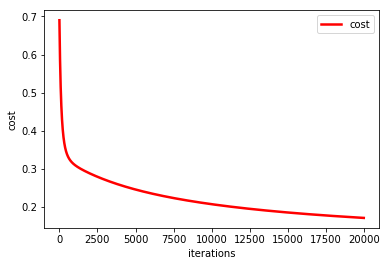

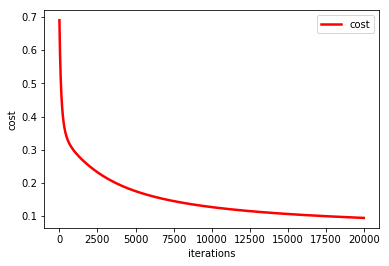

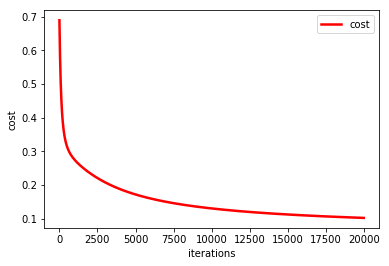

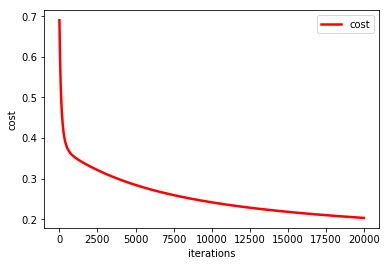

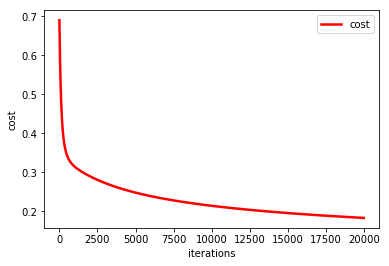

Thetas ready!


In [89]:
alpha = 0.001
rlambda = 3
iters = 100
steps = 200
theta = [0] * len(yversus)
gd    = [0] * len(yversus)

# multiple gradient descent classes and 
# thetas.  One for each type of target
for i in range(len(yversus)):
       
    # make theta a column vector of X feature length
    theta[i] = np.zeros(shape=(XOnes.shape[1], 1))
    gd[i]    = LogisticRegressor(XOnes, yversus[i], theta[i], rlambda)

    plt.xlabel('iterations')
    plt.ylabel('cost')
    costy = []

    for s in range(0, steps):
        g, cost = gd[i].gradientDescent(alpha, iters)
        costy = costy + cost.tolist()
        
    #print(g)
    #print(costy)
    plt.plot(list(range(0, steps*iters)), costy, linestyle="-", color='r', linewidth=2.5, label='cost')
    plt.legend(loc='upper right')
    plt.show()
    
print("Thetas ready!")

In [90]:
m = XOnes.shape[0]
errCount = 0

# Now lets check out our prediction versus actual
# and the confidence.   We're effectively checking
# each of our LinearRegressors to see which one
# of them have the most confidence that the sample
# is in their classified group
#
for i in range(m):
    py = 0.0
    for j in range(len(gd)):
        ptmp = gd[j].predict(XOnes[i])
        if (ptmp > py):
            py = ptmp
            pj = j
        
    if (ymod[i] != pj):
#        print("actual=", ymod[i], "prediction=", pj, "confidence=", py, "<====Prediction error!")
        errCount += 1
#    else:
#       print("actual=", ymod[i], "prediction=", pj, "confidence=", py)
        
print("Samples=", m, "Prediction errors=", errCount, "Success rate=", (m-errCount)/m)

Samples= 5000 Prediction errors= 690 Success rate= 0.862
